In [1]:
#Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Importing dataset
risk_data = pd.read_csv("maternal_health_risk_dataset.csv")

In [3]:
risk_data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
risk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [5]:
risk_data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [6]:
# Check for missing values
print(risk_data.isnull().sum())

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [7]:
# Converting the 'BodyTemp' column from Kelvins to celcius unit
risk_data['BodyTemp'] = risk_data['BodyTemp'].apply(lambda x: round((x-32) * (5/9), 2))
risk_data.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.67,86,high risk
1,35,140,90,13.0,36.67,70,high risk
2,29,90,70,8.0,37.78,80,high risk
3,30,140,85,7.0,36.67,70,high risk
4,35,120,60,6.1,36.67,76,low risk


Data Preparation for Classification

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(risk_data, test_size=0.20, random_state=125)

In [9]:
print('Training dataset:', train.shape)
print('Test dataset:', test.shape)

Training dataset: (811, 7)
Test dataset: (203, 7)


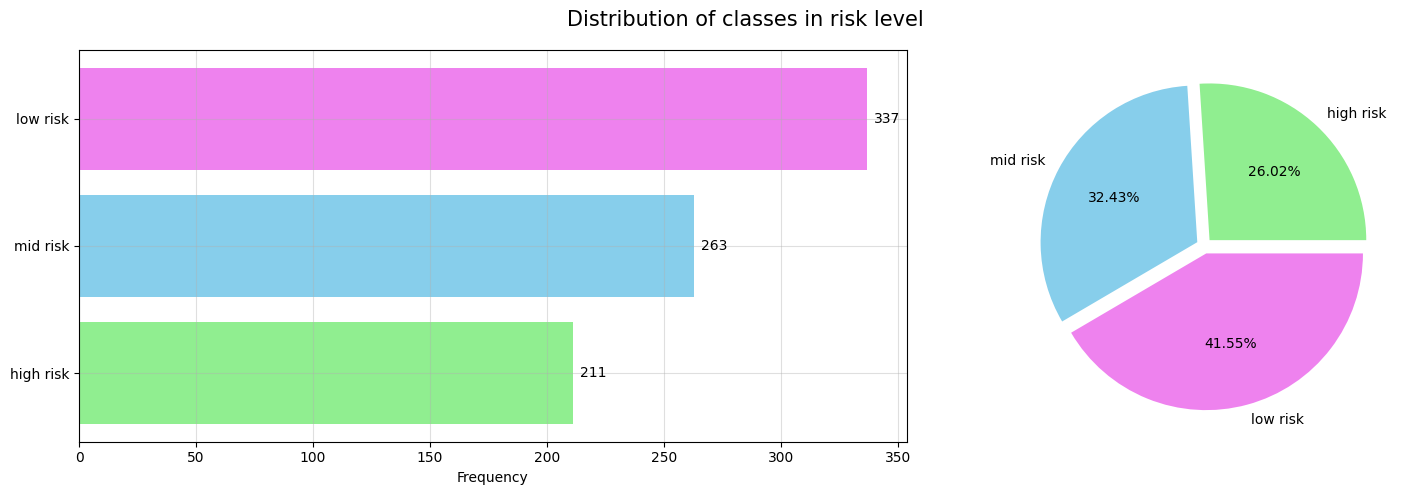

In [10]:
# Visualization
risk = train['RiskLevel'].value_counts(). sort_values()

figure, axes = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios': [1.5, 1]})
axes[0].barh(y=risk.index, width=risk.values, color=['lightgreen', 'skyblue', 'violet'])
axes[0].set_xlabel('Frequency')
axes[0].grid(alpha=0.4)

for index, values in enumerate(risk):
    axes[0].text(values+3, index, str(values), va='center')

axes[1].pie(risk.values, labels=risk.index, colors=['lightgreen', 'skyblue', 'violet'],
            autopct='%.2f%%', explode=[0.05, 0.05, 0.05]
           )
figure.suptitle('Distribution of classes in risk level', fontsize=15)
plt.tight_layout()
plt.show()

In [11]:
# segregate the feature matrix and taget vector from the train and test datasets
Xtrain = train.drop(columns=['RiskLevel'], axis=1)
ytrain = train['RiskLevel']

Xtest = test.drop(columns=['RiskLevel'], axis=1)
ytest = test['RiskLevel']

print('Xtrain: ', Xtrain.shape)
print('ytrain: ', ytrain.shape)
print('Xtest: ', Xtest.shape)
print('ytest: ', ytest.shape)

Xtrain:  (811, 6)
ytrain:  (811,)
Xtest:  (203, 6)
ytest:  (203,)


Classification

Method 1: Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# create a decision tree classifier
tree = DecisionTreeClassifier(random_state=125)

# define the hyperparameter grid
par_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'], 
    'max_depth': [10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, par_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best Accuracy: ', grid_search_tree.best_score_)


Best Parameters:  {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best Accuracy:  0.7645080663485573


In [13]:
# get the model
best_tree = grid_search_tree.best_estimator_

# evaluate the best model for the test set
test_accuracy = best_tree.score(Xtest, ytest)

print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.7635467980295566


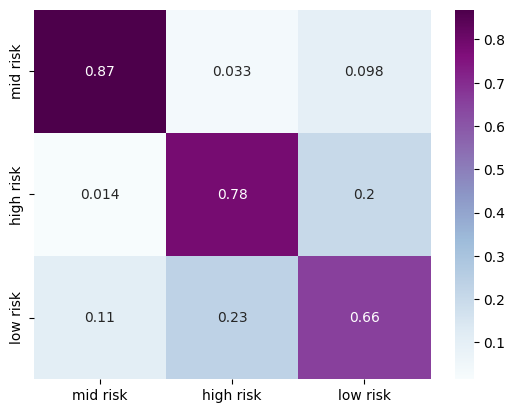

In [14]:
# visualization of the confusion matrix using a heatmap
from sklearn.metrics import confusion_matrix

ypred = best_tree.predict(Xtest)

labels = ytest.unique()

cm_tree = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_tree, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [15]:
# classification report
from sklearn.metrics import classification_report

decision_tree_report = classification_report(ytest, ypred)
print(decision_tree_report)

              precision    recall  f1-score   support

   high risk       0.85      0.87      0.86        61
    low risk       0.74      0.78      0.76        69
    mid risk       0.71      0.66      0.68        73

    accuracy                           0.76       203
   macro avg       0.77      0.77      0.77       203
weighted avg       0.76      0.76      0.76       203



Method 2: Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# create a random forest classifier
forest = RandomForestClassifier(random_state=125)

# define the huperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [2, 4], 
    'max_features': ['sqrt', 'log2']
}

# create the GridSearchCV object
grid_search_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_forest.fit(Xtrain, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_forest.best_params_)
print('Best Accuracy: ', grid_search_forest.best_score_)


Best Parameters:  {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy:  0.7990532454745134


In [ ]:
# get the model
best_forest = grid_search_forest.best_estimator_

# evaluate the best model for the test set
test_accuracy = best_forest.score(Xtest, ytest)

print('Test Accuracy: ', test_accuracy)

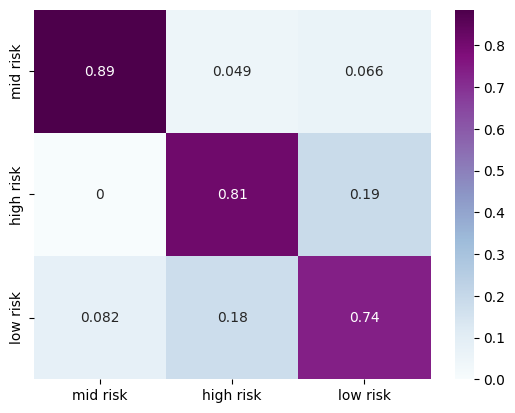

In [18]:
# visualization of the confusion matrix using a heatmap
from sklearn.metrics import confusion_matrix

ypred = best_forest.predict(Xtest)

labels = ytest.unique()

cm_forest = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_forest, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [19]:
# classification report
from sklearn.metrics import classification_report

random_forest_report = classification_report(ytest, ypred)
print(random_forest_report)

              precision    recall  f1-score   support

   high risk       0.90      0.89      0.89        61
    low risk       0.78      0.81      0.79        69
    mid risk       0.76      0.74      0.75        73

    accuracy                           0.81       203
   macro avg       0.81      0.81      0.81       203
weighted avg       0.81      0.81      0.81       203



Method 3: Logistic Regression

In [20]:
# scale the feature matrix of train and test for logistic regression
from sklearn.preprocessing import MinMaxScaler

# create the MinMaxScaler object
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest)

In [21]:
from sklearn.linear_model import LogisticRegression

# create a random forest classifier
log_reg = LogisticRegression(random_state=125, max_iter=2000)

# define the huperparameter grid
par_grid = {
    'penalty': ['l1', 'l2'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga']
}

# create the GridSearchCV object
grid_search_log_reg = GridSearchCV(log_reg, par_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_log_reg.fit(Xtrain_scaled, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_log_reg.best_params_)
print('Best Accuracy: ', grid_search_log_reg.best_score_)


Best Parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy:  0.6337726274331592


In [22]:
# get the model
best_log_reg = grid_search_log_reg.best_estimator_

# evaluate the best model for the test set
test_accuracy = best_log_reg.score(Xtest_scaled, ytest)

print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.6748768472906403


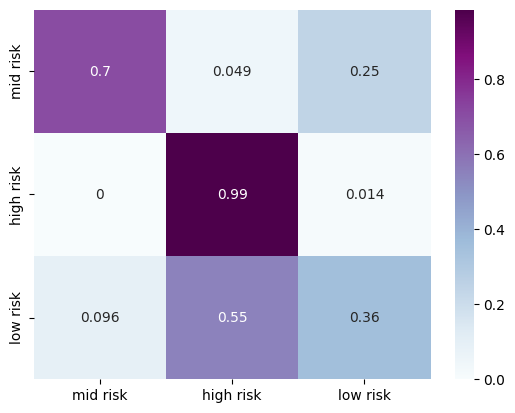

In [23]:
# visualization of the confusion matrix using a heatmap
from sklearn.metrics import confusion_matrix

ypred = best_log_reg.predict(Xtest_scaled)

labels = ytest.unique()

cm_log_reg = confusion_matrix(ytest, ypred, normalize='true')
plt.figure()
sns.heatmap(cm_log_reg, annot=True, cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.show()

In [24]:
# classification report
from sklearn.metrics import classification_report

log_reg_report = classification_report(ytest, ypred)
print(log_reg_report)

              precision    recall  f1-score   support

   high risk       0.86      0.70      0.77        61
    low risk       0.61      0.99      0.76        69
    mid risk       0.62      0.36      0.45        73

    accuracy                           0.67       203
   macro avg       0.70      0.68      0.66       203
weighted avg       0.69      0.67      0.65       203



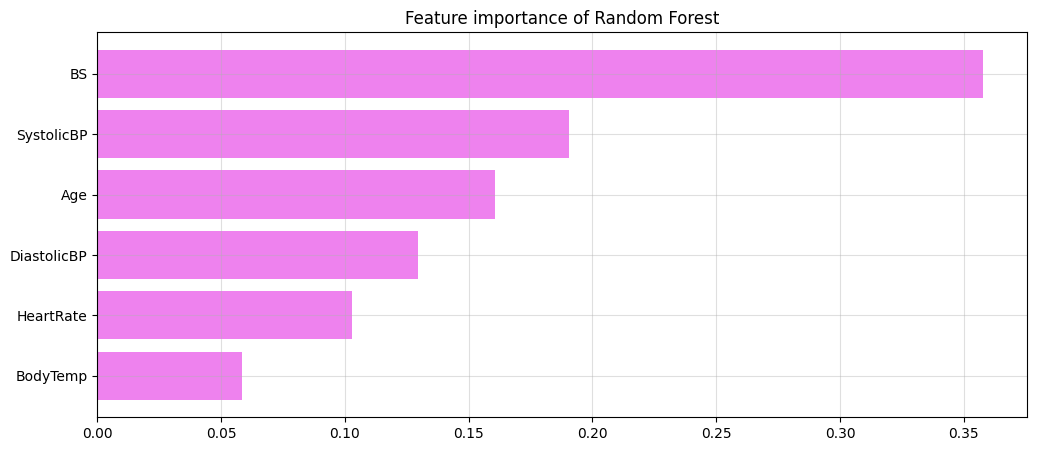

In [25]:
# feature importance of Random Forest
feature_importance = best_forest.feature_importances_

feature_score = pd.Series(feature_importance, index=Xtrain.columns)
score = feature_score.sort_values()

plt.figure(figsize=(12, 5))
plt.barh(y=score.index, width=score.values, color='violet')
plt.grid(alpha=0.4)
plt.title('Feature importance of Random Forest')
plt.show()

Summary:
1. Random Forest model demonstrates an outstanding performance, achieving the highest accuracy, precission and recal scores among the trained models.
2. The Random Forest model's exceptional ability is underscored by the confusion matrix, accuracy identifying all the three risk levels.
3. Feature importance analysis, presented in a plot, highlits blood glucose and systolic blood pressure as the top influential features, collectively contributing approximately 0.5 to the overall feature importance score.